# Wrapper Methods

### Introduction to Wrapper Methods

In machine learning, datasets often have many features, some important, others irrelevant. Wrapper methods help select important features by testing subsets of features based on a model’s performance.

Wrapper methods have two key advantages:

- They evaluate features based on the performance of a specific model.
- They account for relationships between features.

Common wrapper methods include:

- Sequential forward selection
- Sequential backward selection
- Sequential forward floating selection
- Sequential backward floating selection
- Recursive feature elimination

We'll implement these algorithms in Python and evaluate their performance.


In [23]:
import pandas as pd

health = pd.read_csv("../../../assets/csv/dataR2.csv")
health.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1


## Setting Up a Logistic Regression Model

Before using a wrapper method, we first need to specify a machine learning model. We'll train a logistic regression model on health data and evaluate its performance.

We prepare the data by splitting it into two parts: a DataFrame \(X\) containing the independent variables and a Series \(y\) containing the dependent variable.

For example, the dataset could include features like temperature, relative humidity, wind speed, rain, and fire risk index, with the final column indicating whether a fire occurred or not (1 for fire, 0 for no fire).

A logistic regression model provides probabilities indicating how likely an observation belongs to a certain category. In this case, probabilities greater than 0.5 are considered predictions of fire, and probabilities lower than 0.5 indicate no fire.

The accuracy of a logistic regression model reflects the percentage of correct predictions it makes. We can evaluate this to determine how well the model performs.

For instance, if the model achieves 98.4% accuracy, it means it correctly predicts whether a fire occurred 98.4% of the time.


In [24]:
from sklearn.linear_model import LogisticRegression

# Split independent and dependent variables
X = health.iloc[:, :-1]
y = health.iloc[:, -1]

# Logistic regression model
lr = LogisticRegression(max_iter=1000)

# Fit the model
lr.fit(X, y)

# Print the accuracy of the model
print(lr.score(X, y))

0.8017241379310345


## Sequential Forward Selection

- **Definition**: A method that starts with no features and adds one feature at a time.
- **First Step**: Evaluate each feature individually and select the one with the best performance.
- **Subsequent Steps**: Test the model with new feature combinations, adding the feature that improves performance the most.
- **Stopping Criterion**: Stops when the desired number of features is reached.

**Note**: It is a greedy algorithm, prioritizing immediate performance gains.


In [25]:
set1 = {"age", "height", "weight", "resting_heart_rate"}
set2 = {"age", "weight", "blood_pressure", "resting_heart_rate"}

### Sequential Forward Selection with mlxtend

In this section, we implement Sequential Forward Selection (SFS) using the `mlxtend` library to determine if we can achieve accurate predictions with fewer features in our logistic regression model.

The logistic regression model was previously about 80.2% accurate at predicting breast cancer, utilizing nine different features. We aim to reduce this number to just three features.

#### Setting Up SFS Parameters

1. **Model**: We specify the logistic regression model.
2. **k_features**: This parameter defines the number of features to select (in this case, three).
3. **forward**: Set to `True` to indicate we are using forward selection.
4. **floating**: Set to `False` as we are not using floating selection.
5. **scoring**: We choose 'accuracy' to evaluate the feature subsets.
6. **cv**: Set to 0 for this exercise, meaning we will evaluate performance only on the training set.

Next, we fit the SFS model to our features \(X\) and outcome \(y\). The selected features will be revealed in the following exercise.


In [26]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

lr = LogisticRegression(max_iter=1000)

# Sequential forward selection
sfs = SFS(lr, k_features=3, forward=True, floating=False, scoring="accuracy", cv=0)

# Fit the sequential forward selection model
sfs.fit(X, y)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          k_features=(3, 3), scoring='accuracy')

### Evaluating the Result of Sequential Forward Selection

The `sfs` object provides critical information about the Sequential Forward Selection (SFS) process. Its `.subsets_` attribute contains details on the features selected at each step and the model's accuracy after adding each feature.

#### Key Components of `sfs.subsets_`

- **Keys**: Represent the number of features selected at each step.
- **Values**: Contain information such as:
  - `feature_idx`: Indices of selected features.
  - `cv_scores`: Cross-validation scores.
  - `avg_score`: Average accuracy of the model with selected features.
  - `feature_names`: Names of the selected features.

#### Accessing Information

You can extract the selected features and the corresponding model accuracy for any step during the SFS process.

#### Visualization

The `mlxtend` library allows for visualizing how model accuracy changes as features are added, helping to confirm performance improvements during the feature selection process.


('Age', 'Glucose', 'Insulin')
0.7672413793103449


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlxtend/feature_selection/sequential_feature_selector.py:892: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_err = scipy.stats.sem(ary)


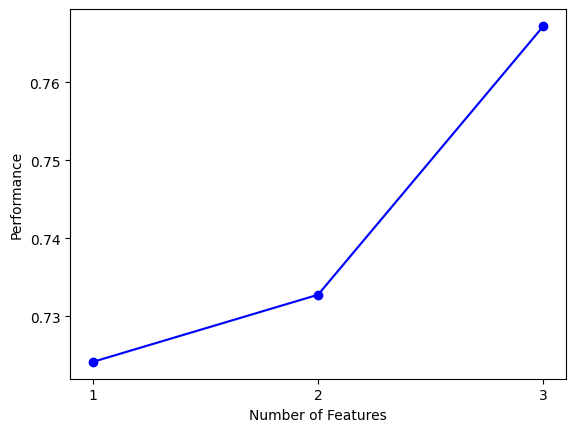

In [27]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

# Load the data
X = health.iloc[:, :-1]
y = health.iloc[:, -1]

# Logistic regression model
lr = LogisticRegression(max_iter=1000)

# Sequential forward selection
sfs = SFS(lr, k_features=3, forward=True, floating=False, scoring="accuracy", cv=0)
sfs.fit(X, y)

# Print the chosen feature names
print(sfs.subsets_[3]["feature_names"])

# Print the accuracy of the model after sequential forward selection
print(sfs.subsets_[3]["avg_score"])

# Plot the model accuracy
plot_sfs(sfs.get_metric_dict())
plt.show()

## Sequential Backward Selection with mlxtend

Sequential Backward Selection (SBS) is a wrapper method for feature selection that operates in the opposite manner of Sequential Forward Selection. Instead of starting with no features, SBS begins with all available features and removes one feature at a time until a specified number of features remains.

#### How It Works

1. **Initial Step**: The algorithm starts with all features.
2. **Feature Removal**: It evaluates multiple subsets by removing one feature at a time and training the model on these subsets.
3. **Selection Criteria**: The feature whose removal results in the best model performance is discarded.
4. **Iterative Process**: This process continues until the desired number of features is reached.

#### Example

For instance, if we have five features: age, height, weight, blood_pressure, and resting_heart_rate, the SBS will train the model on subsets created by removing each feature one by one. The algorithm then evaluates which subset performs the best, iterating this process until it achieves the specified number of features.

#### Implementation in mlxtend

To implement SBS using the `mlxtend` library, you can utilize the same `SFS` class used for forward selection but set the `forward` parameter to `False`.


In [28]:
# Logistic regression model
lr = LogisticRegression(max_iter=1000)

# Sequential backward selection
sbs = SFS(lr, k_features=3, forward=False, floating=False, scoring="accuracy", cv=0)

# Fit the sequential backward selection model
sbs.fit(X, y)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          forward=False, k_features=(3, 3), scoring='accuracy')

### Evaluating the Result of Sequential Backward Selection

- The `sbs.subsets_` attribute contains information about feature subsets at each step.
- It includes:

  - **feature_idx**: Indices of selected features.
  - **cv_scores**: Cross-validation scores.
  - **avg_score**: Average model score for the subset.
  - **feature_names**: Names of the selected features.

- Use `sbs.get_metric_dict()` to visualize model accuracy changes as features are removed.


('Age', 'Glucose', 'Resistin')
0.7413793103448276


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlxtend/feature_selection/sequential_feature_selector.py:892: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_err = scipy.stats.sem(ary)


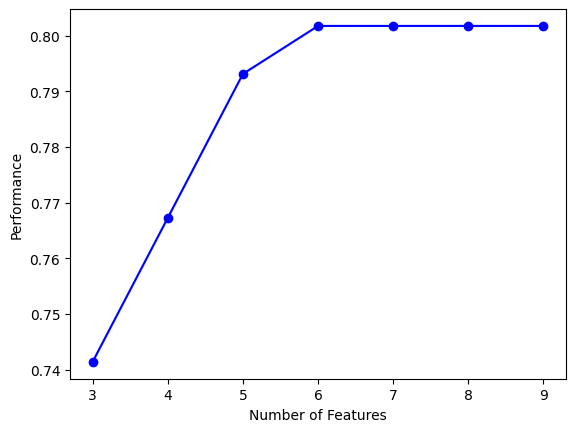

In [29]:
# Evaluate the result of sequential backward selection
print(sbs.subsets_[3]["feature_names"])
print(sbs.subsets_[3]["avg_score"])

# Plot the model accuracy
plot_sfs(sbs.get_metric_dict())
plt.show()

### Sequential Forward and Backward Floating Selection

- **Sequential Forward Floating Selection (SFFS)**:

  - Starts with zero features and adds one feature at a time.
  - After each addition, checks if removing any feature improves performance.
  - If a feature can be removed to enhance performance, it will be removed.
  - Continues adding features unless it leads to an infinite loop of additions and removals.

- **Sequential Backward Floating Selection (SBFS)**:

  - Starts with all features and removes one feature at a time.
  - After each removal, it checks if adding any feature can improve performance.
  - Prevents adding features that would cause infinite loops.

- **Advantages of Floating Selection**:
  - Tests more feature subsets than non-floating methods.
  - Can identify useful relationships between variables that simpler methods might overlook.


### Sequential Forward and Backward Floating Selection with mlxtend

- **Implementation**:

  - Use the `SFS` class from mlxtend for sequential forward or backward floating selection.
  - Set the `floating` parameter to `True` to enable floating selection.
  - The `forward` parameter determines the selection type:
    - `True`: Sequential Forward Floating Selection (SFFS)
    - `False`: Sequential Backward Floating Selection (SBFS)

- **Example of Sequential Backward Floating Selection**:

  - Initialize `SFS` with parameters such as `k_features`, `forward`, `floating`, `scoring`, and `cv`.

- **Feature Names**:
  - Retrieve information about selected features using the `.subsets_` attribute.


In [30]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Load the data
health = pd.read_csv("../../../assets/csv/dataR2.csv")
X = health.iloc[:, :-1]
y = health.iloc[:, -1]

# Logistic regression model
lr = LogisticRegression(max_iter=1000)

# Sequential forward floating selection
sffs = SFS(lr, k_features=3, forward=True, floating=True, scoring="accuracy", cv=0)
sffs.fit(X, y)

# Print a tuple with the names of the features chosen by sequential forward floating selection.
print(sffs.subsets_[3]["feature_names"])

# Sequential backward floating selection
sbfs = SFS(lr, k_features=3, forward=False, floating=True, scoring="accuracy", cv=0)
sbfs.fit(X, y)

# Print a tuple with the names of the features chosen by sequential backward floating selection.
print(sbfs.subsets_[3]["feature_names"])


('Age', 'Glucose', 'Insulin')
('Age', 'Glucose', 'Resistin')


## Recursive Feature Elimination

- **Overview**:

  - Recursive Feature Elimination (RFE) is a wrapper method for feature selection.
  - Starts by training a model with all features, ranks them by importance, and removes the least important feature.

- **Process**:

  1. Train the model on all features.
  2. Rank features based on an importance metric (e.g., regression coefficients).
  3. Remove the least important feature.
  4. Retrain the model with the reduced feature set and repeat until the desired number of features is reached.

- **Ranking Method**:

  - In regression, features are ranked by the absolute values of their coefficients. The feature with the smallest absolute coefficient is considered the least important.

- **Data Standardization**:

  - It's often necessary to standardize data before RFE to ensure that feature scales do not affect coefficient sizes.

- **Comparison with Sequential Backward Selection**:
  - RFE trains the model only once per feature removal, making it generally faster than sequential backward selection, which evaluates multiple subsets.


### Recursive Feature Elimination with scikit-learn

- **Overview**:

  - scikit-learn provides an implementation of Recursive Feature Elimination (RFE) for feature selection.

- **Steps to Implement**:

  1. **Standardization**:

     - Standardize features using `StandardScaler` to ensure consistent scaling of features, especially important for models like logistic regression.

  2. **RFE Setup**:
     - Use `RFE()` from `sklearn.feature_selection`.
     - Specify the model (e.g., logistic regression) as the estimator.
     - Set `n_features_to_select` to the desired number of features to retain.

- **Example Process**:
  - Standardize the data:
    - `X = StandardScaler().fit_transform(X)`
  - Initialize RFE:
    - `rfe = RFE(lr, n_features_to_select=2)`
  - Fit RFE to the data:
    - `rfe.fit(X, y)`


In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# Load the data
X = np.array(health.iloc[:, :-1])
y = np.array(health.iloc[:, -1])

# Standardize the data
X = StandardScaler().fit_transform(X)

# Logistic regression model
lr = LogisticRegression(max_iter=1000)

# Recursive feature elimination
rfe = RFE(estimator=lr, n_features_to_select=3)
rfe.fit(X, y)


RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=3)

### Evaluating the Result of Recursive Feature Elimination

- **Key Attributes**:

  - `rfe.ranking_`:

    - Contains ranks of each feature.
    - A rank of **1** indicates the feature was retained.
    - Higher numbers indicate the order in which features were removed.

  - `rfe.support_`:
    - An array of **True** and **False** values indicating selected features.
    - **True** means the feature was retained, while **False** indicates it was eliminated.

- **Feature Rankings**:
  - Features are ranked based on importance after elimination.
- **Chosen Features**:

  - Use a list comprehension with `rfe.support_` to extract names of retained features.

- **Model Evaluation**:
  - Use `rfe.score(X, y)` to assess the model's accuracy with the selected features.


In [32]:
# Load the data
X = health.iloc[:, :-1]
y = health.iloc[:, -1]

# Create a list of feature names
feature_list = list(X.columns)

# Standardize the data
X = StandardScaler().fit_transform(X)

# Logistic regression
lr = LogisticRegression(max_iter=1000)

# Recursive feature elimination
rfe = RFE(estimator=lr, n_features_to_select=3)
rfe.fit(X, y)

# List of features chosen by recursive feature elimination
rfe_features = [f for (f, support) in zip(feature_list, rfe.support_) if support]

# Print the accuracy of the model with features chosen by recursive feature elimination
print(rfe.score(X, y))


0.7327586206896551
